## Introduction

The name of housing unit types are specific of the Italian market, therefore I create a short dictionary with its translation in English:
- Monolocale: studio flat(one-room apartment)
- Bilocale: two-rooms apartment       
- Trilocale: three-rooms apartment       
- Quadrilocale: four-rooms apartment
- Appartamento: flat/apartment (that is from four to more rooms) 
- Attico: attic           
- Villa: house/villa
- Palazzo: building/palace
- Mansarda: mansard        
- Loft: loft apartment       
- Terratetto: this is a typical italian building of the early year of the 20th century. It means "from the ground to the roof"      
- Open space: open space apartment  
- Casale: farmhouse

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import math
import time

# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import  mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_error

# from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [4]:
df_italia = pd.read_csv('CLEANED_DATASET_RENT_ITALY.csv')
df_italia.drop('Unnamed: 0', axis=1, inplace=True)
df_italia

,Price,Surface,City,Housing_unit,city_size,macroregion,floor,num_rooms,rent_bracket,surface_bracket
0,8500.0,250.0,Milano,Appartamento,big,north,3.0,6,very high,large
1,1150.0,40.0,Milano,Monolocale,big,north,3.0,1,mid-high,small
2,900.0,51.0,Milano,Bilocale,big,north,3.0,2,mid-low,small
3,1550.0,55.0,Milano,Bilocale,big,north,3.0,2,mid-high,small
4,920.0,45.0,Milano,Bilocale,big,north,3.0,2,mid-low,small
...,...,...,...,...,...,...,...,...,...,...
10662,850.0,65.0,Modena,Mansarda,mid-small,north,4.0,2,mid-low,small
10663,1500.0,140.0,Modena,Attico,mid-small,north,4.0,4,mid-high,mid
10664,600.0,25.0,Modena,Bilocale,mid-small,north,4.0,2,low,very small
10665,850.0,70.0,Modena,Bilocale,mid-small,north,4.0,2,mid-low,mid-small


## Remove outliers and suspicious values

Outliers are removed using the IQR and and some suspicious values are deleted. 
For suspicious values I mean those houses/flats with:
- Price rent < 150, because they are probably daily or weekly rents in B&B, while I am focusing on monthly rents 
- Surface < 20 m2, because they are more likely to be scams since they are too small to be said livable

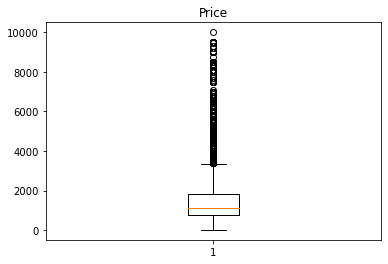

In [88]:
plt.boxplot(df_italia['Price'])
plt.title('Price');

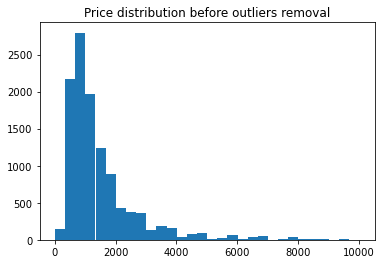

In [89]:
plt.hist(df_italia['Price'], bins = 30)
plt.title('Price distribution before outliers removal');

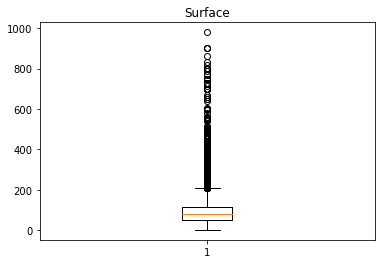

In [90]:
plt.boxplot(df_italia['Surface'])
plt.title('Surface');

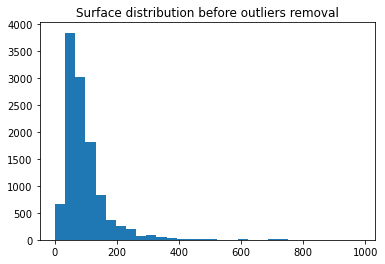

In [91]:
plt.hist(df_italia['Surface'], bins = 30)
plt.title('Surface distribution before outliers removal');

In [92]:
len(df_italia[df_italia['Price']<250]), len(df_italia[df_italia['Surface']<20])

(36, 152)

In [93]:
#Removing suspicious values, that could be scam announcements or daily/weekly rents in B&B
df_italia =df_italia[(df_italia['Surface']>=20) & (df_italia['Price']>=250)]

In [94]:
df_italia.shape

(11190, 7)

In [95]:
def remove_outliers_iqr(df,columns):
    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df


columns_to_check = ['Price','Surface']
df_cleaned = remove_outliers_iqr(df_italia, columns_to_check)

df_cleaned.head()

,Price,N_rooms,Surface,Floor,City,Zone,Housing_unit
1,1150.0,1,40.0,3,Milano,Buenos Aires,Monolocale
2,900.0,2,51.0,3,Milano,Bovisa,Bilocale
3,1550.0,2,55.0,3,Milano,Missori,Bilocale
4,920.0,2,45.0,3,Milano,Città Studi,Bilocale
5,2975.0,4,150.0,3,Milano,Centrale,Quadrilocale


In [96]:
df_cleaned.shape

(9877, 7)

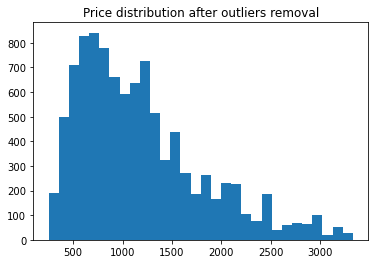

In [97]:
plt.hist(df_cleaned['Price'], bins = 30)
plt.title('Price distribution after outliers removal');

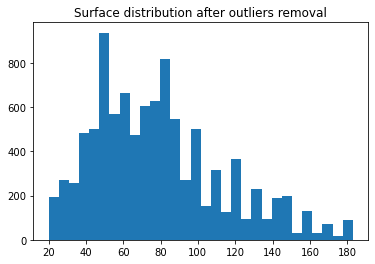

In [98]:
plt.hist(df_cleaned['Surface'], bins = 30)
plt.title('Surface distribution after outliers removal');

# Model Building

## Data preparation

The machine learning algoritms used for model building are Decision Tree, Random Forest, XGBoost and LGBM; the last two are gradient boosting backed algorithms. All of them have a regressor option that was used to predict the rent price.

in particulare, LGBM has a specific procedure for data preparation that require to transform numerical variables into float variables

In [101]:
X = df_cleaned.drop(columns = 'Price', axis = 1)
Y = df_cleaned['Price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 42)
X_train.shape, X_test.shape, X.shape

((6913, 6), (2964, 6), (9877, 6))

## Decision Tree

In [102]:
dt = DecisionTreeRegressor()

start_time = time.time()


param_grid ={
    'max_depth':[2,4,6,8],
    'min_samples_split': [2,4,6,8],
    'min_samples_leaf': [1,2,3,4],
    'max_features': ['auto','sqrt','log2'],
    'random_state': [0,42]
}

grid_search = GridSearchCV(dt, param_grid, cv=5, scoring = 'neg_mean_squared_error') 

grid_search.fit(X_train , Y_train )

print(grid_search.best_params_)

end_time = time.time()
duration = end_time - start_time
print(duration/60)

{'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'random_state': 0}
0.5149002949396769


In [141]:
dt = DecisionTreeRegressor(max_depth=8, max_features='auto', min_samples_leaf=4, min_samples_split=2, random_state=0)
dt.fit(X_train , Y_train )

y_train_pred = dt.predict(X_train)

mae = round(mean_absolute_error(Y_train,y_train_pred), 2) 
mse = round(mean_squared_error(Y_train,y_train_pred), 2)
mape = round(mean_absolute_percentage_error(Y_train,y_train_pred)*100,2)
r2 =round(r2_score(Y_train,y_train_pred)*100,2)
rmse = round( math.sqrt(mse), 2)


print(f"MAE is: {mae}")
print(f"MSE is: {mse}")
print(f"MAPE is: {mape}")
print(f"R2 SCORE is: {r2}")
print(f"RMSE is: {rmse}")

MAE is: 291.37
MSE is: 162195.99
MAPE is: 27.96
R2 SCORE is: 59.61
RMSE is: 402.74


In [142]:
y_pred = dt.predict(X_test)

mae = round(mean_absolute_error(Y_test,y_pred),2)
mse = round(mean_squared_error(Y_test,y_pred),2)
mape = round(mean_absolute_percentage_error(Y_test,y_pred)*100,2)
r2 = round(r2_score(Y_test,y_pred),2)*100
rmse = round(math.sqrt(mse),2)


print(f"MAE is: {mae}")
print(f"MSE is: {mse}")
print(f"MAPE is: {mape}")
print(f"R2 SCORE is: {r2}")
print(f"RMSE is: {rmse}")


df_metrics = pd.DataFrame()
df_metrics = df_metrics.append({'Algorithm':'Decision Tree Regressor', 'MAE €':mae, 'MSE €': mse,  'RMSE €': rmse, 'MAPE %': mape, 'R2 Score %': r2}, ignore_index=True)

MAE is: 313.8
MSE is: 189793.85
MAPE is: 30.15
R2 SCORE is: 53.0
RMSE is: 435.65


## Random Forest

In [105]:
rf = RandomForestClassifier()


start_time = time.time()

RANDOM_STATE = 42

param_grid ={
     'n_estimators':[ 50, 100, 150],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [2, 4, 6, 8],
    'max_features': [1.0, 2.0, 3.0],
    'max_depth': [5, 10, 20],
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring = 'neg_mean_squared_error') 

grid_search.fit(X_train , Y_train )

print(grid_search.best_params_)

end_time = time.time()
duration = end_time - start_time
print(duration/60)

{'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150}
66.5092515707016


In [143]:
RANDOM_STATE = 42

rf = RandomForestClassifier(n_estimators= 150, min_samples_split= 2 , min_samples_leaf= 4, max_features= 1.0, max_depth = 10, random_state=RANDOM_STATE)
rf.fit(X_train , Y_train )

y_train_pred = rf.predict(X_train)

mae = round(mean_absolute_error(Y_train,y_train_pred), 2) 
mse = round(mean_squared_error(Y_train,y_train_pred) , 2) 
mape = round(mean_absolute_percentage_error(Y_train,y_train_pred)*100,2)
r2 = round(r2_score(Y_train,y_train_pred)*100,2)
rmse = round(math.sqrt(mse) , 2) 


print(f"MAE is: {mae}")
print(f"MSE is: {mse}")
print(f"MAPE is: {mape}")
print(f"R2 SCORE is: {r2}")
print(f"RMSE is: {rmse}")

MAE is: 233.57
MSE is: 186547.29
MAPE is: 20.19
R2 SCORE is: 53.55
RMSE is: 431.91


In [144]:
y_pred = rf.predict(X_test)

mae = round( mean_absolute_error(Y_test,y_pred), 2) 
mse = round(mean_squared_error(Y_test,y_pred), 2) 
mape = round(mean_absolute_percentage_error(Y_test,y_pred)*100,2)
r2 = round(r2_score(Y_test,y_pred), 2)*100
rmse = round(math.sqrt(mse), 2) 


print(f"MAE is: {mae}")
print(f"MSE is: {mse}")
print(f"MAPE is: {mape}")
print(f"R2 SCORE is: {r2}")
print(f"RMSE is: {rmse}")


df_metrics = df_metrics.append({'Algorithm':'Random Forest Regressor', 'MAE €':mae, 'MSE €': mse,  'RMSE €': rmse, 'MAPE %': mape, 'R2 Score %': r2 }, ignore_index=True)

MAE is: 334.25
MSE is: 255297.97
MAPE is: 29.52
R2 SCORE is: 37.0
RMSE is: 505.27


## XGBoost

In [124]:
xgb = XGBRegressor()

start_time = time.time()


param_grid ={
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1]
}

grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring = 'neg_mean_squared_error') 

grid_search.fit(X_train , Y_train )

print(grid_search.best_params_)

end_time = time.time()
duration = end_time - start_time
print(duration/60)

{'learning_rate': 0.1, 'n_estimators': 150}
0.4076710025469462


In [145]:
xgb = XGBRegressor(n_estimators= 150, eta=0.1)
xgb.fit(X_train , Y_train )

y_train_pred = xgb.predict(X_train)

mae = round( mean_absolute_error(Y_train,y_train_pred), 2)
mse = round(mean_squared_error(Y_train,y_train_pred), 2)
mape = round(mean_absolute_percentage_error(Y_train,y_train_pred)*100,2)
r2 = round(r2_score(Y_train,y_train_pred)*100,2)
rmse = round(math.sqrt(mse), 2)


print(f"MAE is: {mae}")
print(f"MSE is: {mse}")
print(f"MAPE is: {mape}")
print(f"R2 SCORE is: {r2}")
print(f"RMSE is: {rmse}")

MAE is: 226.73
MSE is: 100726.56
MAPE is: 21.81
R2 SCORE is: 74.92
RMSE is: 317.37


In [146]:
y_pred = xgb.predict(X_test)

mae = round(mean_absolute_error(Y_test,y_pred), 2)
mse = round(mean_squared_error(Y_test,y_pred), 2)
mape = round(mean_absolute_percentage_error(Y_test,y_pred)*100,2)
r2 = round(r2_score(Y_test,y_pred) , 2)*100
rmse = round(math.sqrt(mse) , 2)


print(f"MAE is: {mae}")
print(f"MSE is: {mse}")
print(f"MAPE is: {mape}")
print(f"R2 SCORE is: {r2}")
print(f"RMSE is: {rmse}")

df_metrics = df_metrics.append({'Algorithm':'XGB Regressor', 'MAE €':mae, 'MSE €': mse,  'RMSE €': rmse, 'MAPE %': mape, 'R2 Score %': r2 }, ignore_index=True)

MAE is: 277.89
MSE is: 153864.5
MAPE is: 26.87
R2 SCORE is: 62.0
RMSE is: 392.26


## LGBM

In [127]:
lgbm = LGBMRegressor()

param_grid ={
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1]
}


grid_search = GridSearchCV(lgbm, param_grid, cv=5, scoring = 'neg_mean_squared_error') 

grid_search.fit(X_train , Y_train )

print(grid_search.best_params_)

{'learning_rate': 0.1, 'n_estimators': 150}


In [147]:
# With the LGBM algorithm numerical variables need to be trasnformed into float variables
X_train = X_train.astype(float)
X_test = X_test.astype(float)
Y_train = Y_train.astype(float)
Y_test = Y_test.astype(float)


lgbm = LGBMRegressor(n_estimators= 150 ,learning_rate=0.1)
lgbm.fit(X_train , Y_train )

y_train_pred = lgbm.predict(X_train)

mae = round( mean_absolute_error(Y_train,y_train_pred), 2)
mse = round(mean_squared_error(Y_train,y_train_pred), 2)
mape = round(mean_absolute_percentage_error(Y_train,y_train_pred)*100,2)
r2 = round(r2_score(Y_train,y_train_pred)*100,2)
rmse = round(math.sqrt(mse), 2)


print(f"MAE is: {mae}")
print(f"MSE is: {mse}")
print(f"MAPE is: {mape}")
print(f"R2 SCORE is: {r2}")
print(f"RMSE is: {rmse}")

MAE is: 240.82
MSE is: 112998.81
MAPE is: 23.12
R2 SCORE is: 71.86
RMSE is: 336.15


In [148]:
y_pred = lgbm.predict(X_test)

mae = round(mean_absolute_error(Y_test,y_pred), 2)
mse = round(mean_squared_error(Y_test,y_pred), 2)
mape = round(mean_absolute_percentage_error(Y_test,y_pred)*100,2)
r2 = round(r2_score(Y_test,y_pred), 2)*100
rmse =round( math.sqrt(mse), 2)


print(f"MAE is: {mae}")
print(f"MSE is: {mse}")
print(f"MAPE is: {mape}")
print(f"R2 SCORE is: {r2}")
print(f"RMSE is: {rmse}")

df_metrics = df_metrics.append({'Algorithm':'LGBM Regressor', 'MAE €':mae, 'MSE €': mse,  'RMSE €': rmse, 'MAPE %': mape, 'R2 Score %': r2 }, ignore_index=True)

MAE is: 281.42
MSE is: 156052.14
MAPE is: 27.16
R2 SCORE is: 61.0
RMSE is: 395.03


In [149]:
df_metrics

,Algorithm,MAE €,MSE €,RMSE €,MAPE %,R2 Score %
0,Decision Tree Regressor,313.80,189793.85,435.65,30.15,53.0
1,Random Forest Regressor,334.25,255297.97,505.27,29.52,37.0
2,XGB Regressor,277.89,153864.50,392.26,26.87,62.0
3,LGBM Regressor,281.42,156052.14,395.03,27.16,61.0


##### Observation:

We can see that the model built with the XGB Regressor is the best performing one among the models used, because it obtained the minimum score of MAE (277.89 €), MSE (153864.50 €), RMSE (392.26 €), and the highest R2 score (62%). 

Nevertheless, we can see that the absolute errors are high due to the high variance among Price and Surface variables. Other reasons can be the fact that there are 20 different rent markets from the 20 different cities selected and that the several housing unit types with distinctive characteristcs are considered. All of these may increase the Price variance.